In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.special import gamma

from imripy import halo, constants as c, merger_system as ms, inspiral, waveform, detector, plot_utils
from imripy.inspiral import forces

#import plot_utils as pu

# Accretion Disk Modeling

In [2]:
colors = {"alpha":'blue', "beta":'orange', "dm":'red', 'vac':'gray'}

In [3]:
m1 = 1e5 * c.solar_mass_to_pc
m2 = 1. *  c.solar_mass_to_pc
D = 5e8
sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)

In [4]:
alpha = 0.1
f_edd = 0.1
eps = 0.1
alphaDisk = halo.AlphaDisk(m1, alpha, f_edd, eps)
betaDisk = halo.BetaDisk(m1, alpha, f_edd, eps)

sp_b_alpha = ms.SystemProp(m1, m2, halo.ConstHalo(0.), baryonicHalo = alphaDisk, D=D)
sp_b_beta = ms.SystemProp(m1, m2, halo.ConstHalo(0.), baryonicHalo = betaDisk, D=D)

### Densities

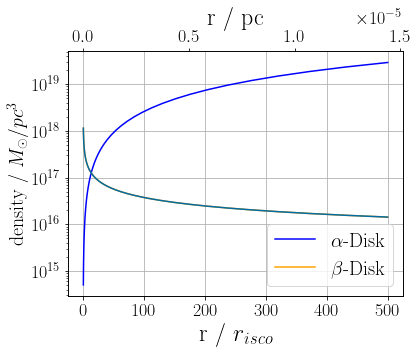

In [25]:
plt.figure(figsize=(6,6 * 6./8.))
r_grid = np.geomspace(2*m1, 500*sp_0.r_isco())
ax_risco = plt.gca()
ax_pc = ax_risco.twiny()
l, = ax_risco.plot(r_grid/sp_0.r_isco(), alphaDisk.density(r_grid)/c.solar_mass_to_pc, label="$\\alpha$-Disk", color=colors["alpha"])
l, = ax_risco.plot(r_grid/sp_0.r_isco(), betaDisk.density(r_grid)/c.solar_mass_to_pc, label="$\\beta$-Disk", color=colors["beta"])
ax_pc.plot(r_grid, betaDisk.density(r_grid)/c.solar_mass_to_pc)

ax_risco.set_yscale('log');# plt.xscale('log') 
ax_risco.set_xlabel("r / $r_{isco}$"); ax_risco.set_ylabel("density / $M_{\odot}/pc^3$", fontsize=20)
ax_pc.set_xlabel("r / pc");
ax_risco.grid(); ax_risco.legend()
plt.savefig("plots/rho_b.pdf", bbox_inches="tight")

### Relative Strength

In [6]:
accuracy = 1e-13
opt_0 = inspiral.Classic.EvolutionOptions(DynamicalFrictionLoss=False, accuracy=accuracy, verbose=1)

opt_gas1 = inspiral.Classic.EvolutionOptions(dissipativeForces={forces.GWLoss(), forces.GasDynamicalFriction()}, 
                                             considerRelativeVelocities=True, progradeRotation=False, accuracy=accuracy, verbose=1)
opt_gas2 = inspiral.Classic.EvolutionOptions(dissipativeForces={forces.GWLoss(), forces.GasInteraction()}, 
                                             considerRelativeVelocities=False, accuracy=accuracy, verbose=1)


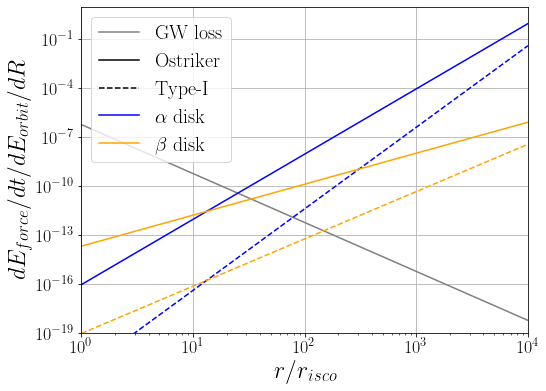

In [24]:
fig= plt.figure(figsize=(8,6))
r = np.geomspace(sp_0.r_isco(), 1e4*sp_0.r_isco(), 100)
ax_risco = plt.gca()
r_grid = np.geomspace(sp_0.r_isco(), 500*sp_0.r_isco())

ax_risco.loglog(r/sp_0.r_isco(), np.abs(forces.GWLoss().dE_dt(sp_0, r, 0., opt_0))/inspiral.Classic.dE_orbit_da(sp_0, r),
                                                                label=r"GW", color=colors["vac"])

l1, = ax_risco.loglog(r/sp_0.r_isco(), np.abs(forces.GasDynamicalFriction().dE_dt(sp_b_alpha, r, e=0., opt=opt_gas1))/inspiral.Classic.dE_orbit_da(sp_b_alpha, r),
                                           label=r"Ostriker", color=colors["alpha"])
ax_risco.loglog(r/sp_0.r_isco(), np.abs(forces.GasInteraction().dE_dt(sp_b_alpha, r, e=0., opt=opt_gas2))/inspiral.Classic.dE_orbit_da(sp_b_alpha, r),
                                           label=r"Type I", color=l1.get_c(), linestyle='--')


l2, = ax_risco.loglog(r/sp_0.r_isco(), np.abs(forces.GasDynamicalFriction().dE_dt(sp_b_beta, r, e=0., opt=opt_gas1))/inspiral.Classic.dE_orbit_da(sp_b_beta, r),
                                                color=colors["beta"])
ax_risco.loglog(r/sp_0.r_isco(), np.abs(forces.GasInteraction().dE_dt(sp_b_beta, r, e=0., opt=opt_gas2))/inspiral.Classic.dE_orbit_da(sp_b_beta, r),
                                              color=l2.get_c(), linestyle='--')

ax_risco.set_xlabel('$r/r_{isco}$'); ax_risco.set_ylabel("$dE_{force}/dt / dE_{orbit}/dR$")
explanatory_lines = [mpl.lines.Line2D([0], [0], color='gray'), 
                          mpl.lines.Line2D([0], [0], color='black'),
                          mpl.lines.Line2D([0], [0], color='black', linestyle='--'),
                          mpl.lines.Line2D([0], [0], color='blue'),
                          mpl.lines.Line2D([0], [0], color='orange')]
ax_risco.legend(explanatory_lines, ['GW loss', 'Ostriker', 'Type-I', "$\\alpha$ disk", "$\\beta$ disk"])
ax_risco.grid()
ax_risco.set_xlim(left=1, right=1e4); ax_risco.set_ylim(bottom=1e-19, top=1e1)
plt.savefig("plots/dEdtdEdR.pdf", bbox_inches="tight")

### Inspiral

In [8]:
a0 = 500. * sp_0.r_isco()
e0 = 0.

In [9]:
ev_0 = inspiral.Classic.Evolve(sp_0, a0, e0, opt=opt_0)
ev_alpha_gas1 = inspiral.Classic.Evolve(sp_b_alpha, a0, e0, opt=opt_gas1)
ev_alpha_gas2 = inspiral.Classic.Evolve(sp_b_alpha, a0, e0, opt=opt_gas2)
ev_beta_gas1 = inspiral.Classic.Evolve(sp_b_beta, a0, e0, opt=opt_gas1)
ev_beta_gas2 = inspiral.Classic.Evolve(sp_b_beta, a0, e0, opt=opt_gas2)

Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-13, DynamicalFrictionLoss=False
A termination event occurred.
 -> Evolution took 0.4054s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, GasDynamicalFriction, }, accuracy = 1.0e-13


/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:314: RuntimeWarning: invalid value encountered in log
  1./2. * np.log((1. + np.abs(v_rel)/c_s)/(1. - np.abs(v_rel)/c_s)) - np.abs(v_rel)/c_s) # subsonic regime
/media/data/Documents/PhD/imripy/src/imripy/merger_system.py:198: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((self.mass(r) + self.m2)/r**3)
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:42: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(sp.m_total(a) *(2./r - 1./a))
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:43: RuntimeWarning: invalid value encountered in sqrt
  v_phi = r * np.sqrt(sp.m_total(a)*a*(1.-e**2))/r**2
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:434: RuntimeWarning: invalid value encountered in sqrt
  v_phi = np.sqrt(self.M/r)
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:419: RuntimeWarning: invalid value encountered in sqrt
  Omega = np.sqrt(se

A termination event occurred.
 -> Evolution took 0.5910s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GasInteraction, GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Evolution took 0.4380s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, GasDynamicalFriction, }, accuracy = 1.0e-13


/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:566: RuntimeWarning: invalid value encountered in sqrt
  v_phi = np.sqrt(self.M/r)
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:551: RuntimeWarning: invalid value encountered in sqrt
  Omega = np.sqrt(self.M/r**3)
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:507: RuntimeWarning: invalid value encountered in scalar power
  * (self.M / 1e6 / c.solar_mass_to_pc)**(1./5.) * (r / 10./self.M)**(-3./5.))


A termination event occurred.
 -> Evolution took 0.4074s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GasInteraction, GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Evolution took 0.3332s


In [10]:
def preparePlots( figF, axesF, axes_ae=None, ax_m=None, axes_a=None, e_min=1e-5, f_min=1e-4, n_b_min=0.):
    figF.subplots_adjust(hspace=0, wspace=0)
    
    if not axes_ae is None:
        for ax in axes_ae:
            ax.set_xlabel('semimajor axis / $r_{isco}$')
            ax.grid()
        axes_ae[0].set_ylabel('eccentricity')

    
    if not axes_a is None:
        for ax in axes_a:
            ax.set_xlabel('time / yr')
            ax.grid()
        axes_a[0].set_ylabel('semimajor axis / $r_{isco}$')

    explanatory_lines = [mpl.lines.Line2D([0], [0], color='gray'), 
                          mpl.lines.Line2D([0], [0], color='black'),
                          mpl.lines.Line2D([0], [0], color='black', linestyle='--'),
                          mpl.lines.Line2D([0], [0], color='blue'),
                          mpl.lines.Line2D([0], [0], color='orange')]
    axes_a[-1].legend(explanatory_lines, ['vacuum', 'Ostriker', 'Type-I', "$\\alpha$ disk", "$\\beta$ disk"], 
                               loc='lower left')
    
    #axesF[0,0].set_ylabel('characteristic strain')
    axesF[0][0].set_ylabel(r'$|\Delta N|$')
    axesF[0][1].set_ylabel(r'dephasing index')
    axesF[0][2].set_ylabel(r'braking index')
    
    axesF[0][-1].set_xlabel('frequency / Hz')
    
    axesF[0][0].set_xlim(left=f_min)
    axesF[0][0].set_ylim(bottom=1., top=1e10)
    axesF[0][2].set_ylim(bottom=n_b_min, top=5)
    axesF[0][1].set_ylim(bottom=-8, top=0)

    for ax in axesF[0]:
        ax.grid()

/media/data/Documents/PhD/imripy/src/imripy/plot_utils.py:113: RuntimeWarning: divide by zero encountered in divide
  ax_di.plot(f_gw1[:stop]/c.hz_to_invpc, (ddN_df/dN * f_gw1)[:stop], color=l.get_c(), **kwargs)


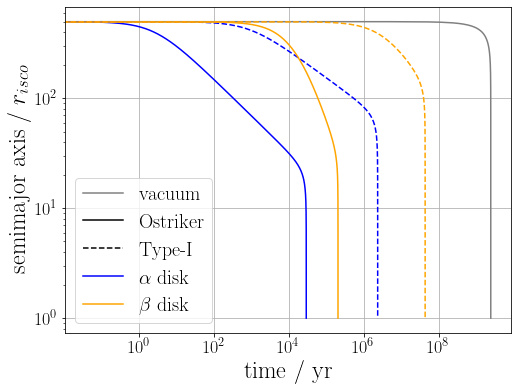

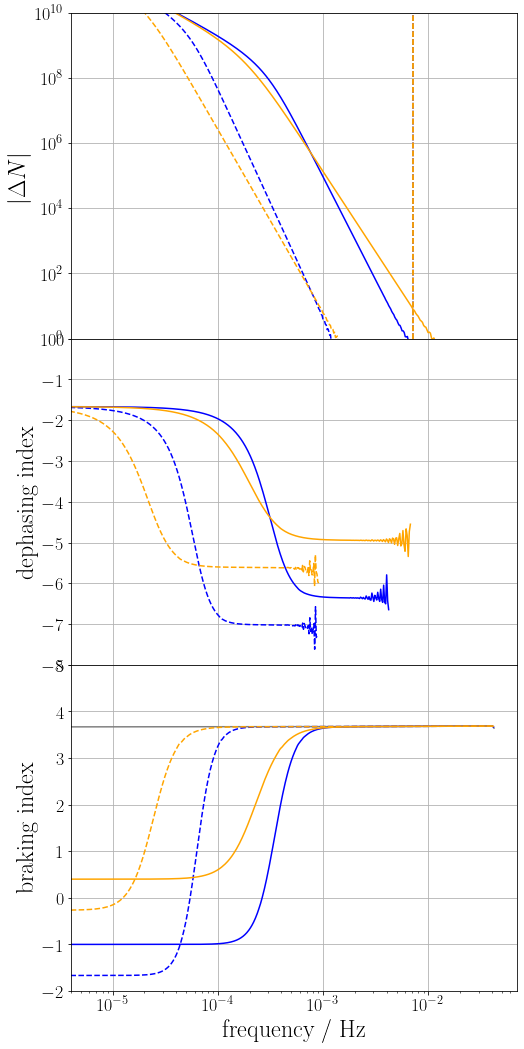

In [11]:
fig_ae, axes_ae = plt.subplots(1, 1, figsize=(8,6))
#fig_ae, axes_ae = plt.subplots(2, 1, figsize=(8,12))
fig_gw, axes_gw = plt.subplots(3, 1, figsize=(8,18), sharex='all', sharey='row')

# vacuum
l = plot_utils.plotEvolution(sp_0, ev_0, ax_a=axes_ae, ax_n=axes_gw[2], label='vacuum', color=colors["vac"])

# accretion disks
l = plot_utils.plotEvolution(sp_b_alpha, ev_alpha_gas1, ax_a=axes_ae, ax_n=axes_gw[2], label='Ostriker', color=colors["alpha"])
plot_utils.plotDeltaN(sp_0, ev_0, sp_b_alpha, ev_alpha_gas1, axes_gw[0], ax_di=axes_gw[1], plotFgw5year=True, color=l.get_c(), label='Ostriker')

l = plot_utils.plotEvolution(sp_b_alpha, ev_alpha_gas2, ax_a=axes_ae, ax_n=axes_gw[2], label='Type I', linestyle='--', color=colors["alpha"])
plot_utils.plotDeltaN(sp_0, ev_0, sp_b_alpha, ev_alpha_gas2, axes_gw[0], ax_di=axes_gw[1], plotFgw5year=True, color=l.get_c(), label='Type I', linestyle='--')

l = plot_utils.plotEvolution(sp_b_beta, ev_beta_gas1, ax_a=axes_ae, ax_n=axes_gw[2], label='Ostriker', color=colors["beta"])
plot_utils.plotDeltaN(sp_0, ev_0, sp_b_beta, ev_beta_gas1, axes_gw[0], ax_di=axes_gw[1], plotFgw5year=True, color=l.get_c(), label='Ostriker')

l = plot_utils.plotEvolution(sp_b_beta, ev_beta_gas2, ax_a=axes_ae, ax_n=axes_gw[2], label='Type I', linestyle='--', color=colors["beta"])
plot_utils.plotDeltaN(sp_0, ev_0, sp_b_beta, ev_beta_gas2, axes_gw[0], ax_di=axes_gw[1], plotFgw5year=True, color=l.get_c(), label='Type I', linestyle='--')

preparePlots( fig_gw, [axes_gw], axes_a=[axes_ae], f_min=4e-6, n_b_min=-2)
fig_ae.subplots_adjust(wspace=0.)

fig_ae.savefig("plots/evolution_baryons.pdf", bbox_inches="tight"); fig_gw.savefig("plots/gwSignal_baryons.pdf", bbox_inches="tight")

# DM vs Baryons

In [12]:
def makeDynamicSpike(sp_stat):
    extPotential = lambda r:sp_stat.m1/r
    r_grid = np.geomspace(1e-1*sp_stat.r_isco(), 1e8*sp_stat.r_isco(), 100)
    Eps_grid = np.geomspace(extPotential(r_grid[-1]), extPotential(r_grid[0]), 500)
    dynSpike = halo.DynamicSS.FromSpike(Eps_grid, sp_stat, sp_stat.halo)
    sp_dyn = ms.SystemProp(sp_stat.m1, sp_stat.m2, dynSpike, sp_stat.D)
    return sp_dyn

In [13]:
# The dark matter spike according to https://arxiv.org/pdf/2108.04154.pdf
rho6 = 5.448e15 * 5**2 * c.solar_mass_to_pc  # in 1/pc^2 
g_spike = 7./3.
sp_dm = makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, g_spike), D))#, label) for alpha,label in alphas]
sps_dm = [(sp_dm, {"label":"DM spike", "color":colors["dm"]}) ]

### Densities

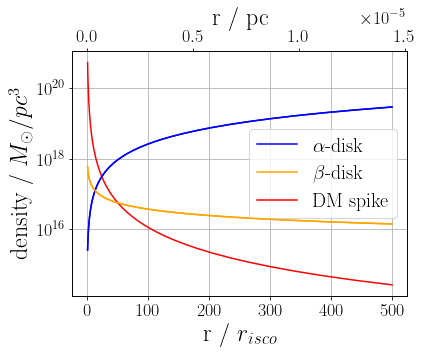

In [23]:
plt.figure(figsize=(6, 6 * 6./8.))
ax_risco = plt.gca()
ax_pc = ax_risco.twiny()
r_grid = np.geomspace(sp_0.r_isco(), 500*sp_0.r_isco())
for disk, kwargs in [(alphaDisk, {"label":"$\\alpha$-disk", "color":colors["alpha"]}), (betaDisk, {"label":"$\\beta$-disk", "color":colors["beta"]})]:
    l, = ax_risco.plot(r_grid/sp_0.r_isco(), disk.density(r_grid)/c.solar_mass_to_pc, label=kwargs["label"], color=kwargs["color"])
    ax_pc.plot(r_grid, disk.density(r_grid)/c.solar_mass_to_pc, color=l.get_c())

for sp, kwargs in sps_dm:
    l, = ax_risco.plot(r_grid/sp_0.r_isco(), sp.halo.density(r_grid)/c.solar_mass_to_pc, label=kwargs["label"], color=kwargs["color"])
    #ax_pc.plot(r_grid, sp.halo.density(r_grid)/ms.solar_mass_to_pc, color=l.get_c())
    
ax_pc.set_xlabel("r / pc"); ax_risco.set_xlabel("r / $r_{isco}$"); ax_risco.set_ylabel(r"density / $M_\odot/pc^3$")
ax_risco.set_yscale('log')
ax_risco.legend(); ax_risco.grid()
plt.savefig("plots/rho_dm.pdf", bbox_inches="tight")#

### Relative Strength

/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:314: RuntimeWarning: invalid value encountered in log
  1./2. * np.log((1. + np.abs(v_rel)/c_s)/(1. - np.abs(v_rel)/c_s)) - np.abs(v_rel)/c_s) # subsonic regime


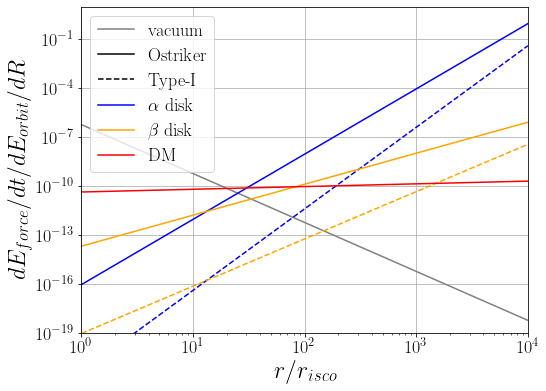

In [22]:
fig= plt.figure(figsize=(8,6))
r = np.geomspace(sp_0.r_isco(), 1e4*sp_0.r_isco(), 100)

plt.loglog(r/sp_0.r_isco(), np.abs(forces.GWLoss().dE_dt(sp_0, r, 0., opt_0))/inspiral.Classic.dE_orbit_da(sp_0, r),
                                                                label=r"GW", color=colors["vac"])

l1, = plt.loglog(r/sp_0.r_isco(), np.abs(forces.GasDynamicalFriction().dE_dt(sp_b_alpha, r, e=0., opt=opt_gas1))/inspiral.Classic.dE_orbit_da(sp_b_alpha, r),
                                           label=r"Ostriker", color=colors["alpha"])
plt.loglog(r/sp_0.r_isco(), np.abs(forces.GasInteraction().dE_dt(sp_b_alpha, r, e=0., opt=opt_gas2))/inspiral.Classic.dE_orbit_da(sp_b_alpha, r),
                                           label=r"Type I", color=l1.get_c(), linestyle='--')


l2, = plt.loglog(r/sp_0.r_isco(), np.abs(forces.GasDynamicalFriction().dE_dt(sp_b_beta, r, e=0., opt=opt_gas1))/inspiral.Classic.dE_orbit_da(sp_b_beta, r),
                                                color=colors["beta"])
plt.loglog(r/sp_0.r_isco(), np.abs(forces.GasInteraction().dE_dt(sp_b_beta, r, e=0., opt=opt_gas2))/inspiral.Classic.dE_orbit_da(sp_b_beta, r),
                                              color=l2.get_c(), linestyle='--')

F_df_dm = forces.DynamicalFriction(haloPhaseSpaceDescription=True)
opt_dm = inspiral.Classic.EvolutionOptions(dissipativeForces={forces.GWLoss(), F_df_dm}, accuracy=accuracy, verbose=1)
plt.loglog(r/sp_0.r_isco(), np.abs(F_df_dm.dE_dt(sp_dm, r, e=0., opt=opt_dm))/inspiral.Classic.dE_orbit_da(sp_dm, r),
                                           label=r"DF", color=colors["dm"])
plt.xlabel('$r/r_{isco}$'); plt.ylabel("$dE_{force}/dt / dE_{orbit}/dR$")
explanatory_lines = [mpl.lines.Line2D([0], [0], color='gray'), 
                          mpl.lines.Line2D([0], [0], color='black'),
                          mpl.lines.Line2D([0], [0], color='black', linestyle='--'),
                          mpl.lines.Line2D([0], [0], color=colors["alpha"]),
                          mpl.lines.Line2D([0], [0], color=colors["beta"]), 
                          mpl.lines.Line2D([0], [0], color=colors["dm"]) ]
plt.legend(explanatory_lines, ['vacuum', 'Ostriker', 'Type-I', "$\\alpha$ disk", "$\\beta$ disk", "DM"], 
                               loc='upper left', fontsize=18) 
plt.grid()
plt.xlim(left=1, right=1e4); plt.ylim(bottom=1e-19, top=1e1)
plt.savefig("plots/dEdtdEdR_dm.pdf", bbox_inches="tight")

### Inspiral

In [16]:
ad_models = [(alphaDisk, "Ostriker", {"label":"$\\alpha$-disk", "color":"purple"}), 
            (betaDisk, "Type-I", {"label":"$\\beta$-disk", "color":"green"}),
           ]
explanatory_lines = [mpl.lines.Line2D([0], [0], color='gray'),
                          mpl.lines.Line2D([0], [0], color=colors["dm"]),
                          mpl.lines.Line2D([0], [0], color="purple"),
                          mpl.lines.Line2D([0], [0], color="green"),
                          mpl.lines.Line2D([0], [0], color="black", linestyle='-.'),
                          mpl.lines.Line2D([0], [0], color="black"), 
                           ]
explanatory_labels = ["vacuum", "DM only", "Ostriker + $\\alpha$-disk", "Type-I + $\\beta$-disk", 
                      "Accretion disk w/o DM", "Accretion disk w/ DM"]


In [17]:
def preparePlots( figF, axesF, axes_ae=None, ax_m=None, axes_a=None, e_min=1e-5, f_min=1e-5, n_b_min=-2.):
    figF.subplots_adjust(hspace=0, wspace=0)
    
    if not axes_ae is None:
        for ax in axes_ae:
            ax.set_xlabel('semimajor axis / $r_{isco}$')
            ax.grid()
        axes_ae[0].set_ylabel('eccentricity')

    if not axes_a is None:
        for ax in axes_a:
            ax.set_xlabel('time / yr')
            ax.grid()
        axes_a[0].set_ylabel('semimajor axis / $r_{isco}$')
        #axes_a[-1].legend(loc='upper left', bbox_to_anchor=(0.9, 1.))
    
    axesF[0,0].set_ylabel(r'$|\Delta N|$')
    axesF[1,0].set_ylabel(r'dephasing index')
    axesF[2,0].set_ylabel(r'braking index')
    

    for ax in axesF[-1,:]:
        ax.set_xlabel('frequency / Hz')

    if axes_a is None and axes_ae is None:
        axesF[1,-1].legend(loc='lower left', bbox_to_anchor=(0.9, 1.))
    
    axesF[0,0].set_xlim(left=f_min)
    axesF[0,0].set_ylim(bottom=1., top=1e10)
    axesF[1,0].set_ylim(bottom=-8, top=0)
    axesF[2,0].set_ylim(bottom=n_b_min, top=5)

    for ax in axesF.flatten():
        ax.grid()

In [18]:
def compareModels(sp_0, sp_dm, ad_models, a0, e0, fudge_factor=1., a_fin=0.,
                  ax_a=None, ax_e=None, ax_ae=None, ax_h=None, ax_dN2=None, ax_ddN2=None, ax_n=None,
                  acc=1e-10):
    
    opt_0 = inspiral.Classic.EvolutionOptions(accuracy=acc, verbose=1)
    F_df_dm = forces.DynamicalFriction(haloPhaseSpaceDescription=True)
    opt_dm = inspiral.Classic.EvolutionOptions(dissipativeForces={forces.GWLoss(), F_df_dm}, accuracy=acc, verbose=1)

    ev_0 = inspiral.Classic.Evolve(sp_0, a0, e0, a_fin=a_fin, opt=opt_0)
    ev_dm = inspiral.Classic.Evolve(sp_dm, a0, e0, a_fin=a_fin, opt=opt_dm)   
    
    l = plot_utils.plotEvolution(sp_0, ev_0, ax_a=ax_a, ax_ae=ax_ae, ax_n=ax_n, label='vacuum')

    l = plot_utils.plotEvolution(sp_dm, ev_dm, ax_a=ax_a, ax_ae=ax_ae, ax_n=ax_n, label='spike', color=colors["dm"])
    plot_utils.plotDeltaN(sp_0, ev_0, sp_dm, ev_dm, ax_dN2, color=l.get_c(), label='spike')
    
    for disk, t, kwargs in ad_models:
        if t == "Ostriker":
            opt_b = inspiral.Classic.EvolutionOptions(dissipativeForces={forces.GWLoss(), forces.GasDynamicalFriction()}, 
                                             considerRelativeVelocities=True, progradeRotation=False, accuracy=acc, verbose=1)
            opt_dm_b = inspiral.Classic.EvolutionOptions(dissipativeForces={forces.GWLoss(), forces.GasDynamicalFriction(), F_df_dm}, 
                                             considerRelativeVelocities=True, progradeRotation=False, accuracy=acc, verbose=1)
        else:
            opt_b = inspiral.Classic.EvolutionOptions(dissipativeForces={forces.GWLoss(), forces.GasInteraction()}, 
                                             considerRelativeVelocities=False, accuracy=acc, verbose=1)
            opt_dm_b = inspiral.Classic.EvolutionOptions(dissipativeForces={forces.GWLoss(), forces.GasInteraction(), F_df_dm}, 
                                             considerRelativeVelocities=False, accuracy=acc, verbose=1)

        sp_b = ms.SystemProp(sp_0.m1, sp_0.m2, halo.ConstHalo(0.), baryonicHalo=disk, D=D)
        sp_dm_b = ms.SystemProp(sp_0.m1, sp_0.m2, sp_dm.halo, baryonicHalo = disk, D=D)
        
        ev_b = inspiral.Classic.Evolve(sp_b, a0, e0, a_fin=a_fin, opt=opt_b)
        ev_dm_b = inspiral.Classic.Evolve(sp_dm_b, a0, e0, a_fin=a_fin, opt=opt_dm_b)
        
        l = plot_utils.plotEvolution(sp_b, ev_b, ax_a=ax_a, ax_ae=ax_ae, ax_n=ax_n, **kwargs, linestyle='-.')
        plot_utils.plotDeltaN(sp_0, ev_0, sp_b, ev_b, ax_dN2, ax_di=ax_ddN2, plotFgw5year=True, **kwargs, linestyle='-.')

        plot_utils.plotEvolution(sp_dm_b, ev_dm_b, ax_a=ax_a, ax_ae=ax_ae, ax_n=ax_n, **kwargs)
        plot_utils.plotDeltaN(sp_0, ev_0, sp_dm_b, ev_dm_b, ax_dN2, ax_di=ax_ddN2, **kwargs)


#### Example

Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Evolution took 0.4025s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Evolution took 1.3064s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, GasDynamicalFriction, }, accuracy = 1.0e-13


/media/data/Documents/PhD/imripy/src/imripy/merger_system.py:198: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((self.mass(r) + self.m2)/r**3)
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:42: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(sp.m_total(a) *(2./r - 1./a))
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:43: RuntimeWarning: invalid value encountered in sqrt
  v_phi = r * np.sqrt(sp.m_total(a)*a*(1.-e**2))/r**2
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:434: RuntimeWarning: invalid value encountered in sqrt
  v_phi = np.sqrt(self.M/r)
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:419: RuntimeWarning: invalid value encountered in sqrt
  Omega = np.sqrt(self.M/r**3)
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:375: RuntimeWarning: invalid value encountered in scalar power
  return 5.4e3 * 0.1*c.g_cm2_to_invpc / (self.alpha/0.1) / (self.f_edd / 0.1 * 0.1 / self

A termination event occurred.
 -> Evolution took 0.5920s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {DynamicalFriction, GWLoss, GasDynamicalFriction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Evolution took 2.0398s


/media/data/Documents/PhD/imripy/src/imripy/plot_utils.py:113: RuntimeWarning: divide by zero encountered in divide
  ax_di.plot(f_gw1[:stop]/c.hz_to_invpc, (ddN_df/dN * f_gw1)[:stop], color=l.get_c(), **kwargs)


Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, GasInteraction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Evolution took 0.3217s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GasInteraction, DynamicalFriction, GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Evolution took 1.2900s


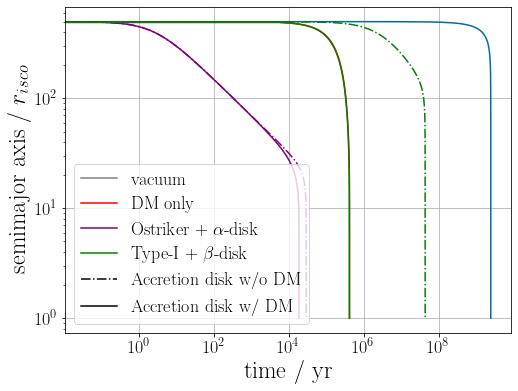

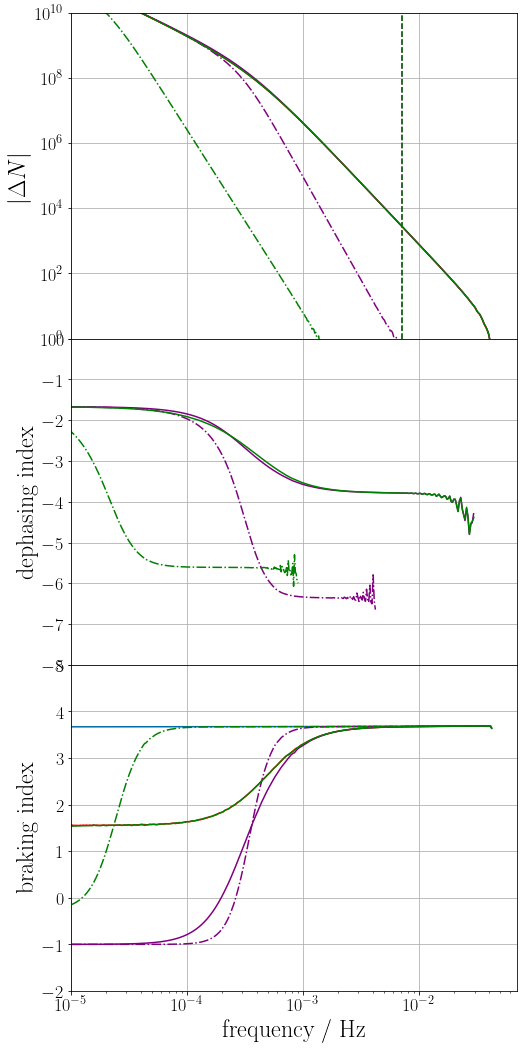

In [19]:
# An example case
figT, axes_ae = plt.subplots(1, 1, figsize=(8,6))
figF, axes_gw = plt.subplots(3, 1, sharex='col', figsize=(8,18))

# Set initial conditions for orbital evolution
a0 = 500 * sp_0.r_isco()
e0 = 0.

compareModels(sp_0, sps_dm[0][0], ad_models, a0, e0, acc=1e-13,
                      ax_a=axes_ae,  ax_dN2=axes_gw[0], ax_ddN2=axes_gw[1], ax_n=axes_gw[2])

preparePlots(figF, np.array([ [axes_gw[0]], [axes_gw[1]], [axes_gw[2]] ]), axes_a=[axes_ae])

#axes_ae[1].set_yscale('log')
axes_ae.legend(explanatory_lines, explanatory_labels, loc='lower left', fontsize=18) 
figT.savefig("plots/evolution_example.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_example.pdf", bbox_inches="tight")

#### Varying intial ecccentricity

Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 10.4757s
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative Forces emplyed {DynamicalFriction, GWLoss, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 36.7936s
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative Forces emplyed {GasDynamicalFriction, GWLoss, }, accuracy = 1.0e-12


/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:93: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:115: RuntimeWarning: invalid value encountered in sqrt
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:115: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:207: RuntimeWarn

A termination event occurred.
 -> Evolution took 26.6013s
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative Forces emplyed {DynamicalFriction, GasDynamicalFriction, GWLoss, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 94.7545s
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative Forces emplyed {GWLoss, GasInteraction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 6.6333s
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative Forces emplyed {DynamicalFriction, GasInteraction, GWLoss, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 48.0526s
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.01  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Evolution took 7.2797s
Evolving from  500.0  t

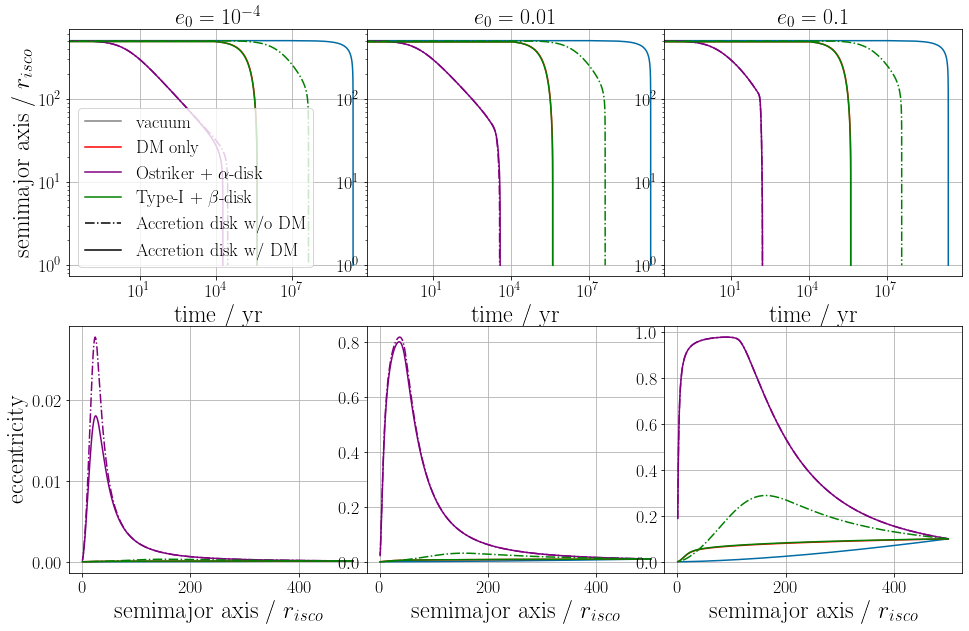

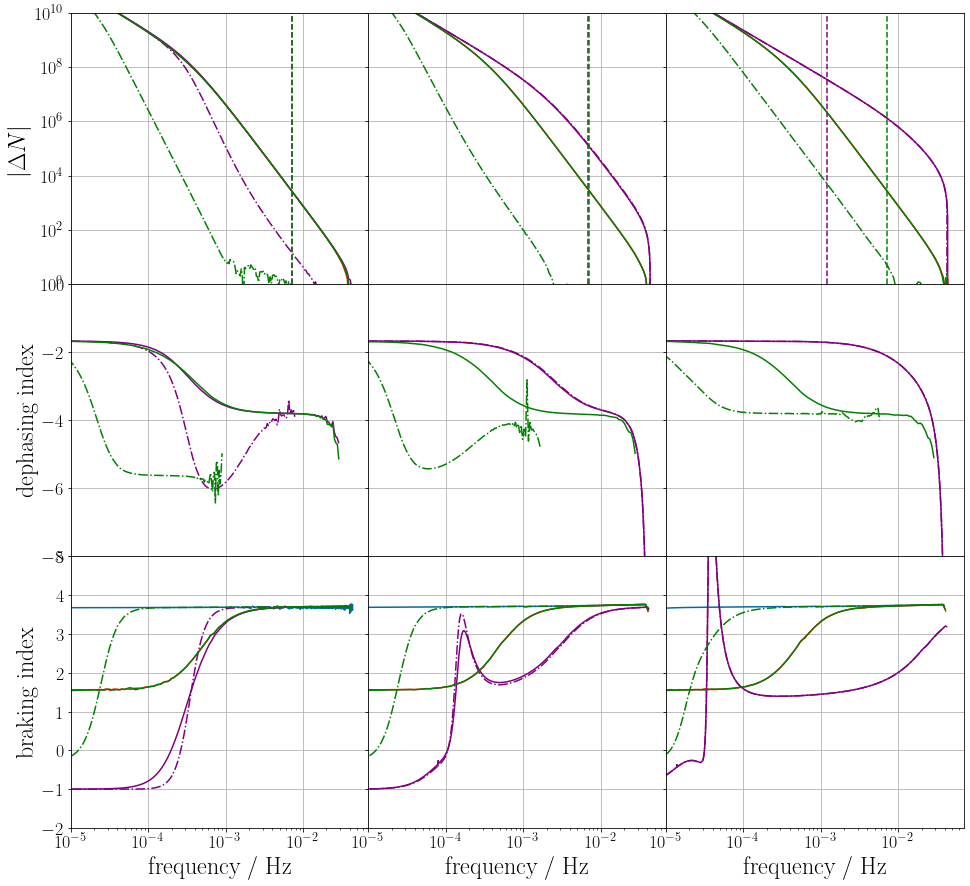

In [20]:
# Look at different initial eccentricities
figT, axesT = plt.subplots(2, 3, figsize=(16, 10))
figF, axesF = plt.subplots(3, 3, figsize=(16, 15), sharex='all', sharey='row')
# Set initial conditions for orbital evolution
a0 = 500 * sp_0.r_isco()

e0 = 1e-4
axesT[0,0].set_title(r"$e_0=10^{-4}$", fontsize=22);# axesF[0,0].set_title(r"$e_0=10^{-4}$")
compareModels(sp_0, sps_dm[0][0], ad_models, a0, e0, acc=1e-12,
              ax_a=axesT[0,0], ax_ae=axesT[1,0], ax_dN2=axesF[0,0], ax_ddN2=axesF[1,0], ax_n=axesF[2,0])
e0 = 0.01
axesT[0,1].set_title(r"$e_0=0.01$", fontsize=22);# axesF[0,1].set_title(r"$e_0=0.1$")
compareModels(sp_0, sps_dm[0][0], ad_models, a0, e0, acc=1e-11,
              ax_a=axesT[0,1], ax_ae=axesT[1,1], ax_dN2=axesF[0,1], ax_ddN2=axesF[1,1], ax_n=axesF[2,1])
e0 = 0.1
axesT[0,2].set_title(r"$e_0=0.1$", fontsize=22); #axesF[0,2].set_title(r"$e_0=0.6$")
compareModels(sp_0, sps_dm[0][0], ad_models, a0, e0, acc=1e-11,
              ax_a=axesT[0,2], ax_ae=axesT[1,2], ax_dN2=axesF[0,2], ax_ddN2=axesF[1,2], ax_n=axesF[2,2])

preparePlots( figF, axesF, axes_ae = axesT[1,:], axes_a=axesT[0,:])
figT.subplots_adjust(wspace=0)
axesT[0,0].legend(explanatory_lines, explanatory_labels, loc='lower left', fontsize=18) 
axesT[0,0].set_yscale('log')
figT.savefig("plots/evolution_e0.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_e0.pdf", bbox_inches="tight")

#### Varying central mass

Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 0.5789s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {DynamicalFriction, GWLoss, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 1.3312s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GasDynamicalFriction, GWLoss, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 0.6438s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GasDynamicalFriction, DynamicalFriction, GWLoss, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 2.1771s
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, GasInteraction, }, accuracy = 1.0

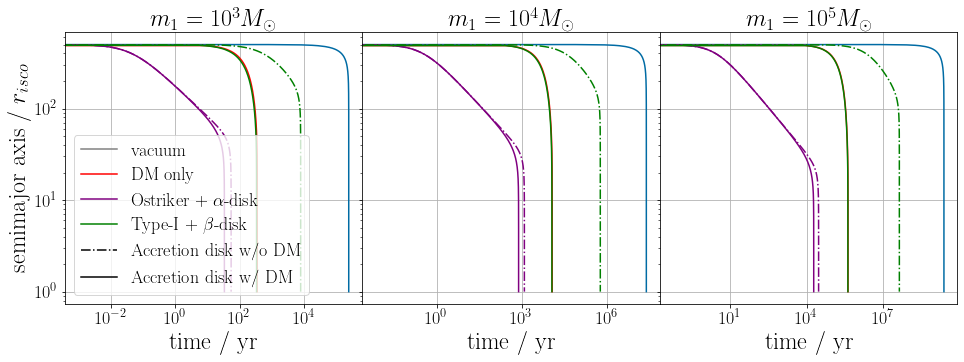

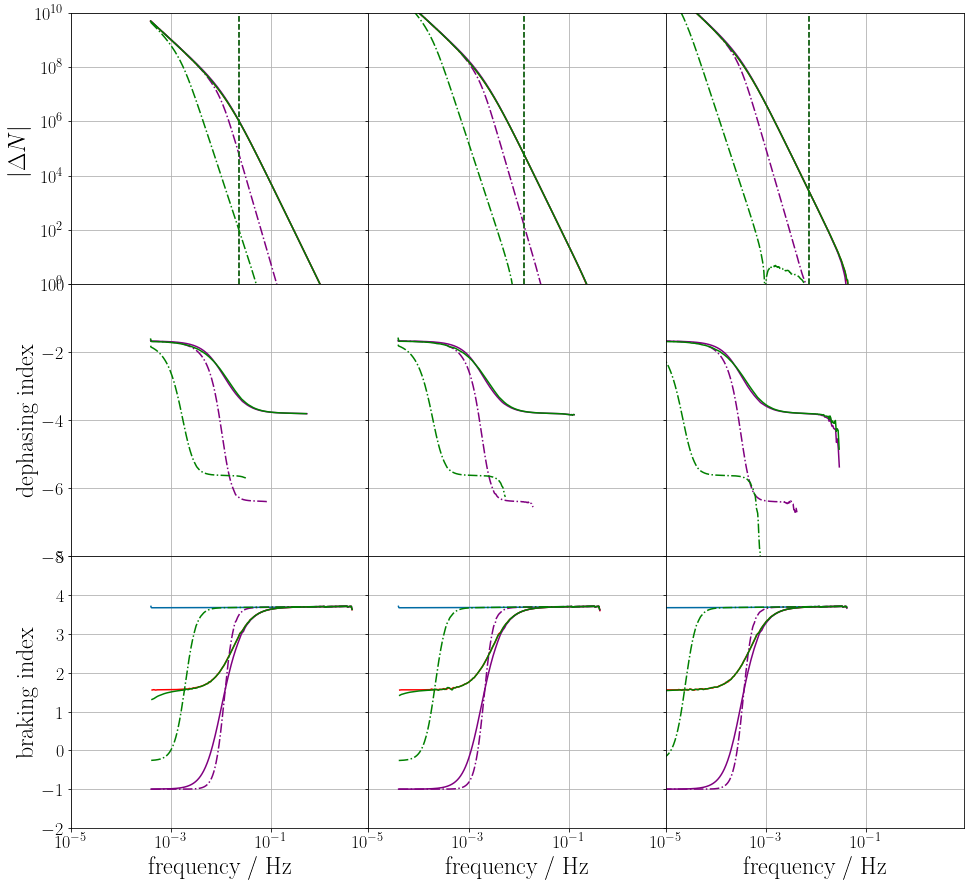

In [21]:
# Look at different m1
figT, axesT = plt.subplots(1, 3, figsize=(16,5), sharey='row')
figF, axesF = plt.subplots(3, 3, figsize=(16,15), sharex='all', sharey='row')

e0 = 0.

# 1
rho6 = 5.448e15 * c.solar_mass_to_pc
m1 = 1e3 * c.solar_mass_to_pc
sp_0_1 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)
sp_dm_1 = makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, g_spike), D))#, label) for alpha,label in alphas]
ad_models_1 = [(halo.AlphaDisk(m1, alpha, f_edd, eps), "Ostriker", {"label":"alphaDisc", "color":"purple"}), 
            (halo.BetaDisk(m1, alpha, f_edd, eps), "Type-I", {"label":"betaDisc", "color":"green"})]
a0 = 5e2*sp_0_1.r_isco()
axesT[0].set_title(r"$m_1 = 10^3 M_{\odot}$"); #axesF[0,0].set_title(r"$m_1 = 10^3 M_{\odot}$")
compareModels(sp_0_1, sp_dm_1, ad_models_1, a0, e0,
              ax_a=axesT[0], ax_dN2=axesF[0,0], ax_ddN2=axesF[1,0], ax_n=axesF[2,0], acc=1e-12)

# 2
m1 = 1e4 * c.solar_mass_to_pc
rho6 = rho6 = 5.448e15 * 5. * c.solar_mass_to_pc
sp_0_2 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)
sp_dm_2 = makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, g_spike), D))#, label) for alpha,label in alphas]
ad_models_2 = [(halo.AlphaDisk(m1, alpha, f_edd, eps), "Ostriker", {"label":"alphaDisc", "color":"purple"}), 
            (halo.BetaDisk(m1, alpha, f_edd, eps), "Type-I", {"label":"betaDisc", "color":"green"})]
a0 = 5e2*sp_0_2.r_isco()
axesT[1].set_title(r"$m_1 = 10^4 M_{\odot}$"); #axesF[0,1].set_title(r"$m_1 = 10^4 M_{\odot}$")
compareModels(sp_0_2, sp_dm_2, ad_models_2, a0, e0,
              ax_a=axesT[1], ax_dN2=axesF[0,1], ax_ddN2=axesF[1,1], ax_n=axesF[2,1], acc=1e-12)
# 3
m1 = 1e5 * c.solar_mass_to_pc
rho6 = rho6 = 5.448e15 * 5.**2 * c.solar_mass_to_pc
sp_0_3 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)
sp_dm_3 = makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, g_spike), D))#, label) for alpha,label in alphas]
ad_models_3 = [(halo.AlphaDisk(m1, alpha, f_edd, eps), "Ostriker", {"label":"alphaDisc", "color":"purple"}), 
            (halo.BetaDisk(m1, alpha, f_edd, eps), "Type-I", {"label":"betaDisc", "color":"green"})]
a0 = 5e2*sp_0_3.r_isco()
axesT[2].set_title(r"$m_1 = 10^5 M_{\odot}$"); #axesF[0,2].set_title(r"$m_1 = 10^5 M_{\odot}$")
compareModels(sp_0_3, sp_dm_3, ad_models_3, a0, e0,
              ax_a=axesT[2], ax_dN2=axesF[0,2], ax_ddN2=axesF[1,2], ax_n=axesF[2,2], acc=1e-12)

preparePlots(figF, axesF, axes_a=axesT)
axesT[0].legend(explanatory_lines, explanatory_labels, loc='lower left', fontsize=18) 
figT.subplots_adjust(wspace=0)
figT.savefig("plots/evolution_m1.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_m1.pdf", bbox_inches="tight")